In [1]:
import numpy as np
import os, sys
import json

project_root = os.path.abspath("")  # alternative
if project_root[-12:] == 'LyoSavin2023':
    base_dir = project_root
else:
    base_dir = os.path.dirname(project_root)
sys.path.append(os.path.join(base_dir, 'core'))
sys.path.append(os.path.join(base_dir, 'core/utils'))

import torch
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import time
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
import zarr

from utils import remove_all_ticks_and_labels

# training a model during the oscillation

In [76]:
def train_model_online(model, dataset, n_epochs, n_steps=100, schedule='sine', device='cpu'):
    model = model.to(device)
    model.train()
    dataset = dataset.to(device)
    
    betas, alphas, _, _, alphas_bar_sqrt, _, one_minus_alphas_bar_sqrt = forward_process(n_steps, device, schedule)
    
    def generate_noisy_sample_for_lambda(x_0, l):
        # x0 multiplier
        a = extract(alphas_bar_sqrt, l, x_0)
        
        # epsilon multiplier
        am1 = extract(one_minus_alphas_bar_sqrt, l, x_0)
        
        # epsilon
        e_l = torch.randn_like(x_0, device=device)
        
        x_l = a*x_0 + am1*e_l
        return x_l, e_l

    
    def reverse_process_one_step(model, x_t, eps_t, t, x_0):
        '''one step of the reverse process. takes a noisy data sample x_{t} and returns a less noisy sample x_{t+1}.'''
        from utils import extract
        
        t = torch.tensor([t], device=device)
        T = t.repeat(x_t.shape[0], 1)
        
        # Model output
        x_t = x_t.detach()
        eps_hat = model(x_t, T)
        
        # compute error
        # loss = (eps_hat - eps_t).square().mean()
        
        # Factor to the model output
        eps_factor = ((1 - extract(alphas, t, x_t)) / extract(one_minus_alphas_bar_sqrt, t, x_t))

        # Final values
        mean = (1 / extract(alphas, t, x_t).sqrt()) * (x_t - (eps_factor * eps_hat))
        
        # calculate loss and update
        loss = (mean - x_0).square().mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Generate z
        z = torch.randn_like(x_t, device=device)
        
        # Fixed sigma
        sigma_t = extract(betas, t, x_t).sqrt()
        sample = mean + sigma_t * z
        
        return sample, z
    
    
    for i in tqdm(range(int(num_epochs)), total=int(num_epochs), desc='Training model', unit='epochs', miniters=int(num_epochs)/100, maxinterval=float("inf")):
        # grab a random sample from the dataset
        x_0 = dataset[np.random.randint(0, len(dataset))].reshape(1, -1)
        
        for l in reversed(range(100)):
            if l==99:
                x_l, e_l = generate_noisy_sample_for_lambda(x_0, l=torch.tensor([l], device=device)) 
            else:
                x_l, e_l = reverse_process_one_step(model, x_l, e_l, l, x_0)
            
        for l in range(n_steps):
            x_l, e_l = reverse_process_one_step(model, x_l, e_l, l, x_0)
        
    return model
            

In [77]:
# -------------------------- set model parameters -------------------------- #
model_name = 'online-learning'
model_type = 'fc'
model_number = 2
num_steps = 100
forward_schedule = 'sine'
# num_hidden = [8, 8, 7, 7]  # 4 layers
num_hidden = 128
num_ambient_dims = 2
num_epochs = 1e3
manifold_type = 'swiss_roll'
manifold_noise_amount = 0
# manifold_rotation_angle = 'np.pi/4'
dataset_size = int(2e3)
batch_size = 128
learning_rate = 3e-4

pretrained_model = {
    'use_pretrained_model_weights': False,
    'use_checkpoint_weights': False,
    'checkpoint_epoch': 1490000,
    'model_name': model_name,
    'model_num': 1
}

# -------------------------- save model description -------------------------- #
description = {
    'model_name': model_name,
    'model_type': model_type,
    'model_number': model_number,
    'num_steps': num_steps,
    'forward_schedule': forward_schedule,
    'num_hidden': num_hidden,
    'num_ambient_dims': num_ambient_dims,
    'num_epochs': f'{num_epochs:.1e}',
    'manifold_type': manifold_type,
    'manifold_noise_amount': manifold_noise_amount,
    # 'manifold_rotation_angle': manifold_rotation_angle,
    'dataset_size': f'{dataset_size:.0e}',
    'batch_size': batch_size,
    'learning_rate': f'{learning_rate:.0e}',
    'use_pretrained_model': pretrained_model['use_pretrained_model_weights'],
}
if pretrained_model['use_pretrained_model_weights']:
    description['pretrained_model_name'] = pretrained_model['model_name']
    description['pretrained_model_num'] = pretrained_model['model_num']
    if pretrained_model['use_checkpoint_weights']:
        description['pretrained_checkpoint_epoch'] = pretrained_model['checkpoint_epoch']

json_savedir = os.path.join(base_dir, 'core/model_description')
model_name_and_number = f'{model_name}_{model_number}'
json_name = f'{model_name_and_number}.json'
with open(os.path.join(json_savedir, json_name), 'w') as file:
    json.dump(description, file)

global device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}', flush=True)

from prior_utils import forward_process
from utils import noise_estimation_loss, save_model_weights, extract
from models import VariableDendriticCircuit, NoiseConditionalEstimatorConcat
from dataset_utils import load_unimodal_data_nd, generate_2d_swiss_roll


def save_checkpoint(epoch, model_state_dict, optimizer_state_dict, loss, model_name, model_number):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model_state_dict,
        'optimizer_state_dict': optimizer_state_dict,
        'loss': loss
    }
    save_path = os.path.join(base_dir, 'core/saved_weights', f'{model_name}_{model_number}', f'epoch={epoch}')
    from pathlib import Path
    Path(save_path).mkdir(parents=True, exist_ok=True)
    torch.save(checkpoint, os.path.join(save_path, 'checkpoint.pt'))

# ------------------------------ define dataset ------------------------------ #
dataset = generate_2d_swiss_roll(dataset_size, rescaled=True, return_as_tensor=True)[1]

# -------------------------------- load model -------------------------------- #
# model = VariableDendriticCircuit(hidden_cfg=num_hidden, num_in=num_ambient_dims, num_out=num_ambient_dims, bias=True) 

model = NoiseConditionalEstimatorConcat(num_hidden=num_hidden)

# -------------------- TRAINING - reverse diffusion process ------------------ #

# define model
if pretrained_model['use_pretrained_model_weights']:
    if pretrained_model['use_checkpoint_weights']==False:
        from utils import load_model_weights
        pretrained_model_name = pretrained_model['model_name']
        pretrained_model_num = pretrained_model['model_num']
        print(f'taking weights from pretrained model {pretrained_model_name}_{pretrained_model_num}!')
        model = load_model_weights(model, pretrained_model_name, pretrained_model_num, device)
    elif pretrained_model['use_checkpoint_weights']==True:
        from utils import load_model_weights_from_chkpt
        model, num_steps, ambient_dims = load_model_weights_from_chkpt(pretrained_model['model_name'], pretrained_model['model_num'], epoch_number=pretrained_model['checkpoint_epoch'], device=device)
        print('model weights loaded from checkpoint!', flush=True)


# training parameteres
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
if pretrained_model['use_pretrained_model_weights'] and pretrained_model['use_checkpoint_weights']==True:
    from utils import load_optimizer_state_dict
    optimizer = load_optimizer_state_dict(optimizer, pretrained_model['model_name'], pretrained_model['model_num'], epoch_number=pretrained_model['checkpoint_epoch'], device=device)
    print('optimizer state dict loaded from checkpoint!', flush=True)

run_dir = os.path.join(base_dir, 'demos/runs', f'{model_name}_{model_number}')
tb = SummaryWriter(run_dir)
start_time = time.time()


model = train_model_online(model, dataset, num_epochs, num_steps, forward_schedule, device=device)


end_time = time.time()
duration = end_time - start_time
duration_mins = duration / 60
print(f'training took {duration:.0f} seconds, which is {duration_mins:.2f} minutes.')

save_model_weights(model, model_name, model_number)

Using device: cpu


Training model:   0%|          | 0/1000 [00:00<?, ?epochs/s]

training took 179 seconds, which is 2.99 minutes.
model state dict saved in directory: /Users/blyo/Documents/research/research/LyoSavin2023/core/saved_weights/online-learning_2.pt


In [78]:
# analysis
from utils import load_model_description
model_name = 'online-learning'
model_version_number = 2

model_details = load_model_description(model_name, model_version_number)
if model_details['model_type'] == 'dendritic':
    from models import VariableDendriticCircuit
    model = VariableDendriticCircuit(hidden_cfg=model_details['num_hidden'], num_in=model_details['num_ambient_dims'], num_out=model_details['num_ambient_dims'], bias=True)
elif model_details['model_type'] == 'fc':
    from models import NoiseConditionalEstimatorConcat
    model = NoiseConditionalEstimatorConcat(num_hidden=model_details['num_hidden'])

# load model weights
from utils import load_model_weights
model = load_model_weights(model, model_name, model_version_number, device=device)

model.eval()

model loaded!


NoiseConditionalEstimatorConcat(
  (condlin1): NoiseConditionalLinearConcat(
    (linear): Linear(in_features=3, out_features=128, bias=True)
  )
  (condlin2): NoiseConditionalLinearConcat(
    (linear): Linear(in_features=129, out_features=128, bias=True)
  )
  (condlin3): NoiseConditionalLinearConcat(
    (linear): Linear(in_features=129, out_features=128, bias=True)
  )
  (linear): Linear(in_features=128, out_features=2, bias=True)
  (nonlin): ReLU()
  (sigmoid): Sigmoid()
)

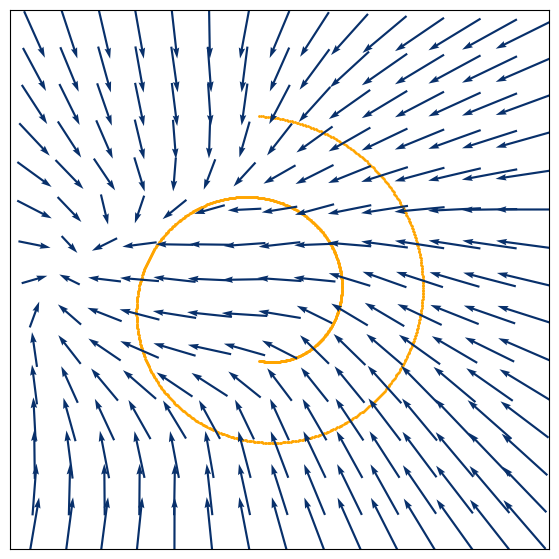

In [81]:
# plot score function
from dataset_utils import generate_2d_swiss_roll
num_samples_in_gt_manifold = 1e3
dataset = generate_2d_swiss_roll(num_samples_in_gt_manifold, True)[1]

# ----------------- calculate flow field for diffusion model ----------------- #
lim=1.5
num_vectors_per_dim=15
from likelihood_utils import calculate_prior_score_flow_field
score_xs, score_ys, color = calculate_prior_score_flow_field(model, lim, num_vectors_per_dim, t=0)

# ----------------------------------- plot ----------------------------------- #
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.scatter(*dataset[:, :2].T, s=1, alpha=1, c='orange')
q = ax.quiver(np.linspace(-lim, lim, num_vectors_per_dim), np.linspace(-lim, lim, num_vectors_per_dim), 
          score_xs, score_ys, 
          color,
          cmap='Blues',
          angles='xy', scale_units='xy', pivot='mid',
        #   scale=12,  # 47
          scale=10,
          clim=(0, .1))
ax.set_aspect('equal')
from utils import remove_all_ticks_and_labels
_=remove_all_ticks_and_labels(ax)